## Project: What makes movie more profitable? 

This project focuses on analysis of the return generated by the movie production. The goal is to understand what parameters lead to higher returns and lower risks. 

### Data collection

Data is collected from "https://www.themoviedb.org" using the website API. The allower download rate is 40 items/movies per 10 seconds. Besides they change movie id database every day. We downloaded the data in chunks of 1000 and combine them filtering data with both zero budget and revenue. It appears that only 1.9% out of all downloaded data contains information about budget and revenue (not zeros). Finally, we have saved the collected data to csv file (final_movie_data.csv) that contains 5390 unique movies.

### Data analysis

Interesting insights:

* More than half of the movies are in losses, to be exact 50.7% movies have negative return.
* Outliers compose 2.65% of the data. We define outliers as movies with more than 3000% return (more than 1000% return for movies made with budget under $500). These movies are removed from most of the analysis since deserve to be considered separately. They should be used to understand an extroardinary performance of the movie in terms of return, which is way more difficult problem to model/predict if even possible.

Here the movie profitability is defined by (revenue - budget)/budget * 100%.

In [53]:
#import necessary libraries
import pandas as pd
import numpy as np

import preprocess_fncs as prep

import matplotlib.pyplot as plt
%matplotlib inline

#display options
from IPython.display import display
pd.options.display.float_format = '{:.2f}'.format

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.8)

import warnings
#warnings.SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [38]:
#read the collected data
df_init = pd.read_csv('final_movie_data.csv',index_col=0)

#preprocess data, details are in preprocess_fncs.py
df = prep.preprocess(df_init)

In [39]:
#filter the outliers in terms of return
filter_cond = ((df['gain/loss_%'] < 1000) & (df['budget_M'] < 0.0005)) \
                | ((df['gain/loss_%'] < 3000) & (df['budget_M'] >= 0.0005))

no_filter = (df['budget_M'] >= 0)

In [40]:
#First look at the data: show summary of the data
#numeric data
display(df[no_filter].describe())

#categorical data
first_cols = [col for col in list(df.columns) 
             if col.startswith('first')]
display(df[no_filter].describe(include=['object'])[['title']+first_cols])

,year,budget_M,revenue_M,return_M,gain/loss_%,runtime
count,5390.00,5390.00,5390.00,5390.00,5390.00,5390.00
mean,1957.98,26.34,72.50,46.16,1038138.75,108.59
std,292.13,62.94,155.62,138.33,57601744.31,37.54
min,0.00,0.00,-0.00,-3499.05,-300.00,1.00
25%,1995.00,2.00,1.89,-0.38,-117.98,94.00
50%,2006.00,10.50,16.16,3.66,-4.92,105.00
75%,2012.00,30.00,71.28,40.59,203.82,121.00
max,2020.00,3500.05,2787.97,2550.97,4166449800.00,2000.00


,title,first_genres,first_production_countries,first_production_companies
count,5390,5390,5390,5390
unique,5312,20,82,2322
top,King Kong,Drama,United States of America,missing
freq,3,1305,2975,450


50.7% of movies have losses.


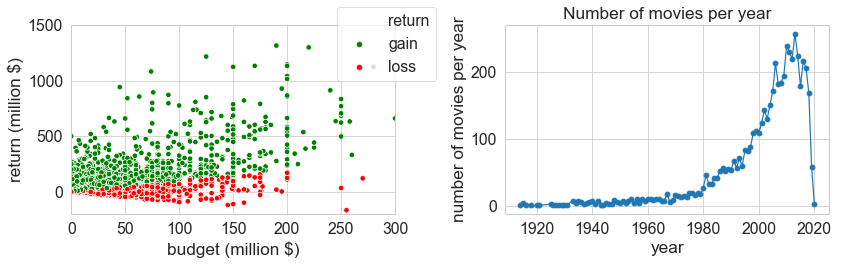

In [57]:
#How budget influence on total revenue in millions?
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

#plot return vs budget in millions $
sns.scatterplot(x='budget_M', y='return_M', hue='return_type',
                data=df, s=30, ax=ax1,palette=['green','red'])

#change axis labels
ax1.set_xlabel('budget (million $)')
ax1.set_ylabel('return (million $)')

#legend parameters
ax1.legend(loc='right',bbox_to_anchor = [1.15, 0.9])\
   .texts[0].set_text("return")

#change axis limits
ax1.set_xlim(0,300)
ax1.set_ylim(-200,1500)

#What is the percentage of movies with negative return?
neg_return = round(df[(df['gain/loss_%'] < 0)].shape[0] 
                   / df.shape[0] * 100,1)

#plot number of movies per a year
df[(df.year > 0)].year.value_counts().sort_index()\
                    .plot(kind='line',marker='o',ax=ax2,
                          title = 'Number of movies per year')

#change axis labels
ax2.set_xlabel('year')
ax2.set_ylabel('number of movies per year')

plt.tight_layout()

print(f'{neg_return}% of movies have losses.')

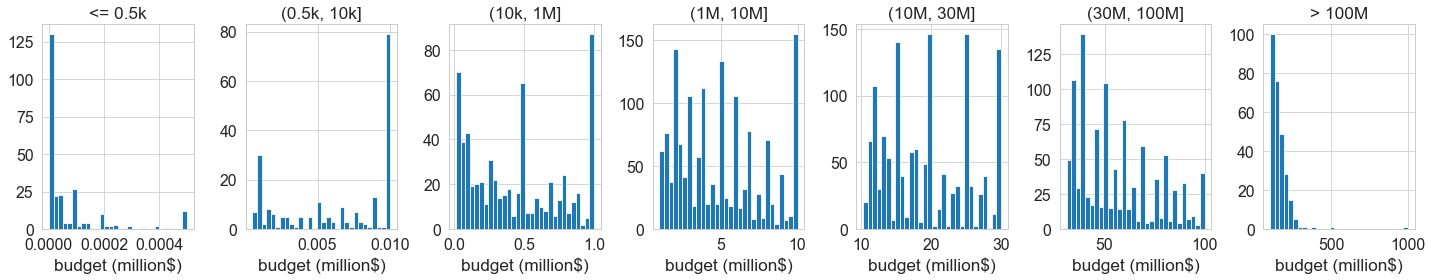

In [42]:
#Define budget categories:
budget_cats = df.budget_category.unique().dropna()
budget_cats = [budget_cats[i] for i in [5,6,3,4,2,0,1]]

#plot all histograms for different categories
fig, ax = plt.subplots(1,len(budget_cats),figsize=(20,4))

for i, cat in enumerate(budget_cats): #[5,6,3,4,2,0,1]
    df[df.budget_category == cat].budget_M.hist(bins=30,ax=ax[i]) #under 0.5k
    ax[i].set_xlabel('budget (million$)')
    ax[i].set_title(cat)
    plt.tight_layout()

,Q1,Q2 (median),Q3
budget,,,
<= 0.5k,3520.00,11800.00,499800.00
"(0.5k, 10k]",5857.40,10911.11,17800.00
"(10k, 1M]",4853.92,9800.00,17341.42
"(1M, 10M]",3563.23,4795.24,6267.28
"(10M, 30M]",3080.62,3080.62,3080.62


budget,<= 0.5k,"(0.5k, 10k]","(10k, 1M]","(1M, 10M]","(10M, 30M]","(30M, 100M]",> 100M
"fraction of removed movies, %",14.73,6.31,10.75,2.16,0.07,0.00,0.00


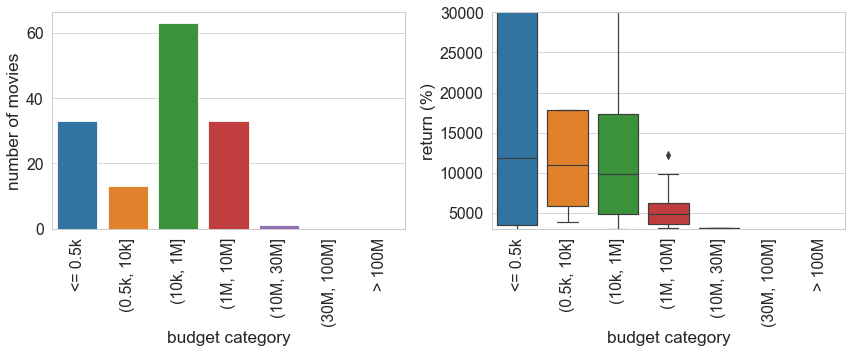

In [43]:
#count plot and box plot of the removed by the filter data
prep.plot_count_box(df,~filter_cond,(3000,30000))

#display summary table with quantiles
display(prep.table_Q123(df,~filter_cond).dropna(axis=0))


#count number of remover movies
filter_count = df[~filter_cond].groupby('budget_category')['budget_category'].count()
keep_count = df[filter_cond].groupby('budget_category')['budget_category'].count()

d = pd.DataFrame(filter_count/keep_count*100)
d.index.names = ['budget']
d.columns = ['fraction of removed movies, %']
display(d.transpose())

,Q1,Q2 (median),Q3
budget,,,
<= 0.5k,-120.56,-100.00,0.00
"(0.5k, 10k]",-100.00,-39.02,248.98
"(10k, 1M]",-100.00,37.08,393.11
"(1M, 10M]",-146.73,-10.47,222.78
"(10M, 30M]",-139.07,-36.39,148.46
"(30M, 100M]",-107.78,-17.77,111.93
> 100M,-13.48,76.47,219.55


,<= 0.5k,"(0.5k, 10k]","(10k, 1M]","(1M, 10M]","(10M, 30M]","(30M, 100M]",> 100M
budget_category,224,206,586,1529,1373,1050,278


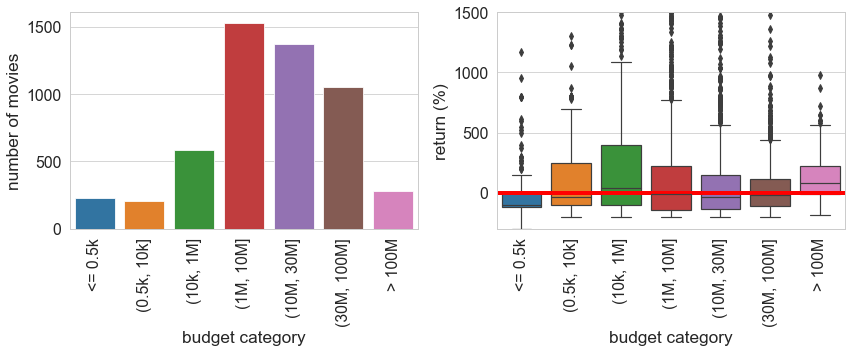

In [44]:
#plot count and box plot of the filtered data
prep.plot_count_box(df,filter_cond,(-300,1500))

#display summary table with quantiles
display(prep.table_Q123(df,filter_cond))

#display the table with number of movies in each category
display(df[filter_cond].budget_category.value_counts()\
        .to_frame().transpose().iloc[:,[5,6,3,0,1,2,4]])

The only movies with positive median are in (10k, 1M] and >100M budget categories.

In [45]:
#show summary of the filtered data
#numeric data
display(df[filter_cond].describe())

#categorical data
display(df[filter_cond].describe(include=['object'])[['title']+first_cols])

#calculate amount of data removed by the filtering
remove_data = round(-(filter_cond.sum() - no_filter.sum())
                    /no_filter.sum()*100,2)
print(f'Remove {remove_data}% of the data.')

,year,budget_M,revenue_M,return_M,gain/loss_%,runtime
count,5247.00,5247.00,5247.00,5247.00,5247.00,5247.00
mean,1959.78,27.03,72.53,45.49,114.29,108.85
std,287.24,63.65,156.73,139.06,415.61,37.52
min,0.00,0.00,-0.00,-3499.05,-300.00,1.00
25%,1995.00,2.16,1.96,-0.58,-121.31,94.00
50%,2006.00,11.50,16.15,3.40,-13.75,105.00
75%,2012.00,32.00,69.92,39.63,175.06,121.00
max,2020.00,3500.05,2787.97,2550.97,2943.21,2000.00


,title,first_genres,first_production_countries,first_production_companies
count,5247,5247,5247,5247
unique,5177,20,82,2255
top,The Three Musketeers,Drama,United States of America,missing
freq,3,1266,2891,431


Remove 2.65% of the data.


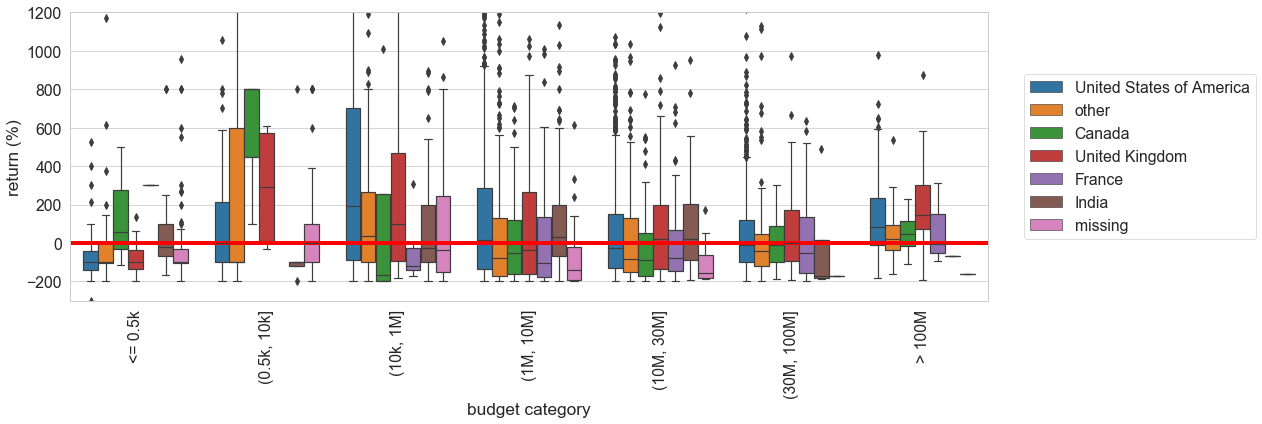

In [46]:
#How country influence the return in different budget categories?
prep.plot_return_filter(df,filter_add = filter_cond,
                        hue_by = 'select_production_countries',
                        hue_order = df.select_production_countries.unique(),
                        _xlim = (-0.5,6.5),
                        _ylim = (-300,1200),
                        _title = '',
                        _bbox_to_anchor = [1.3, 0.5])

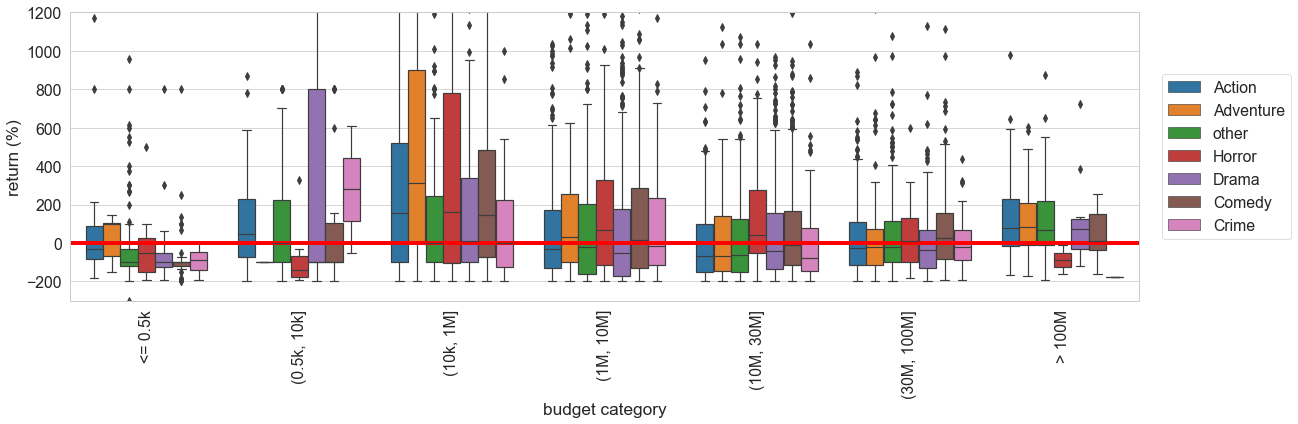

In [47]:
#How genre influence the return in different budget categories?
prep.plot_return_filter(df,filter_add = filter_cond,
                        hue_by = 'select_genres',
                        hue_order = list(df.select_genres.unique()),
                        _xlim = (-0.5,6.5),
                        _ylim = (-300,1200),
                        _title = '')

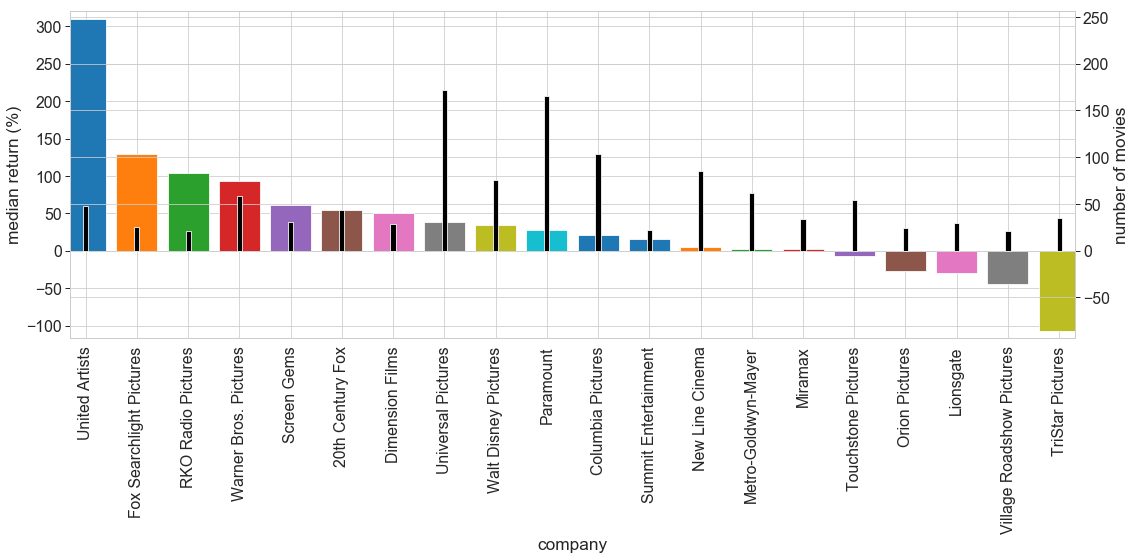

In [48]:
#How production company influence the return in different budget categories?
fig, ax1 = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for different companies
#filter other and missing company for plotting
filter_other_company = (df.select_production_companies != 'other') 
filter_missing_company = (df.select_production_companies != 'missing') 

group = df[filter_cond & filter_other_company & filter_missing_company]\
                       .groupby('select_production_companies')['gain/loss_%']\
                       .agg(['median','count'])\
                       .sort_values(by='median',ascending=False).iloc[:20]
#plot
group['median'].plot(kind='bar',ax=ax1,width=0.8)#pos

#change axis labels
ax1.set_ylabel('median return (%)')
ax1.set_xlabel('company')
f1, f2 = (5.8, 1.6)
ax1.set_ylim(-20*f1,200*f2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
group['count'].plot(kind='bar',ax=ax2,color='k',width=0.1)
ax2.set_ylabel('number of movies')
_ = ax2.set_ylim(-16*f1,160*f2)

In [49]:
#Having sufficient data, optimize return (max median) 
#and minimaze risk (min std) for budget category and company
d = df[filter_cond & filter_other_company 
               & filter_missing_company]\
               .groupby(['budget_category'
                         ,'select_production_companies'
                         ])['gain/loss_%']\
               .agg(['count','median','std'])

d[d['count']>20].sort_values(by=['median','std'],axis=0,
                           ascending=[False,True]).head(12)

count  median    std
budget_category select_production_companies                      
(1M, 10M]       United Artists                  25  626.92 594.67
                Paramount                       41  200.00 584.44
                Universal Pictures              37  160.00 854.12
                Warner Bros. Pictures           22   65.80 523.63
(10M, 30M]      Universal Pictures              67   52.40 360.02
                20th Century Fox                22   50.57 354.53
(30M, 100M]     Walt Disney Pictures            31   22.47 375.81
                New Line Cinema                 23   19.60 201.55
(1M, 10M]       Metro-Goldwyn-Mayer             27   12.27 125.16
(30M, 100M]     Columbia Pictures               45   11.50 147.98
                Universal Pictures              55    7.53 273.56
(10M, 30M]      Columbia Pictures               27    6.81 255.51

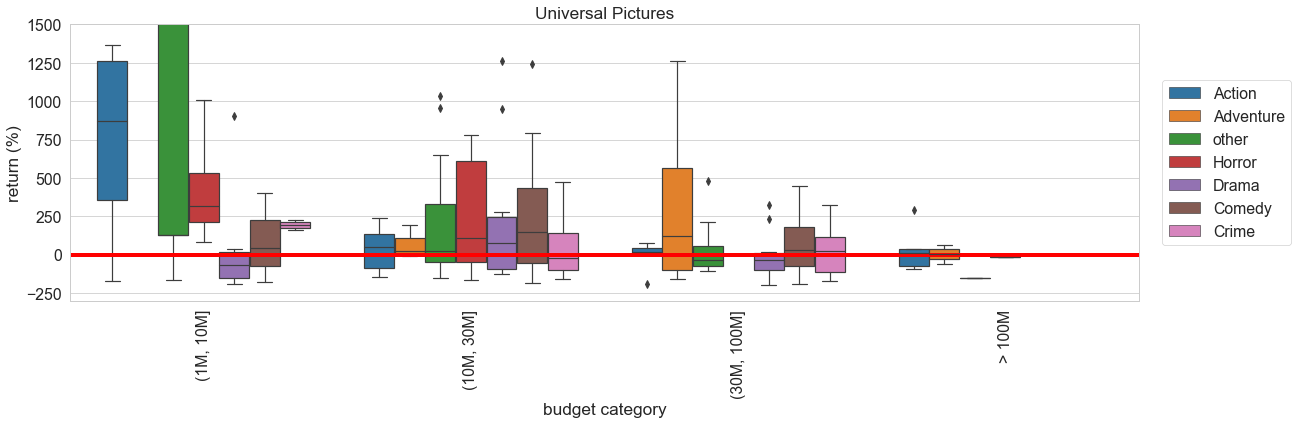

In [50]:
# return vs budget for specific production company
company = 'Universal Pictures' 
filter_UP = (df.first_production_companies == company)
prep.plot_return_filter(df,filter_add = filter_cond & filter_UP,
                   hue_by = 'select_genres',
                   hue_order = list(df.select_genres.unique()),
                   _xlim = (2.5,6.5),
                   _ylim = (-300,1500),
                   _title = company)

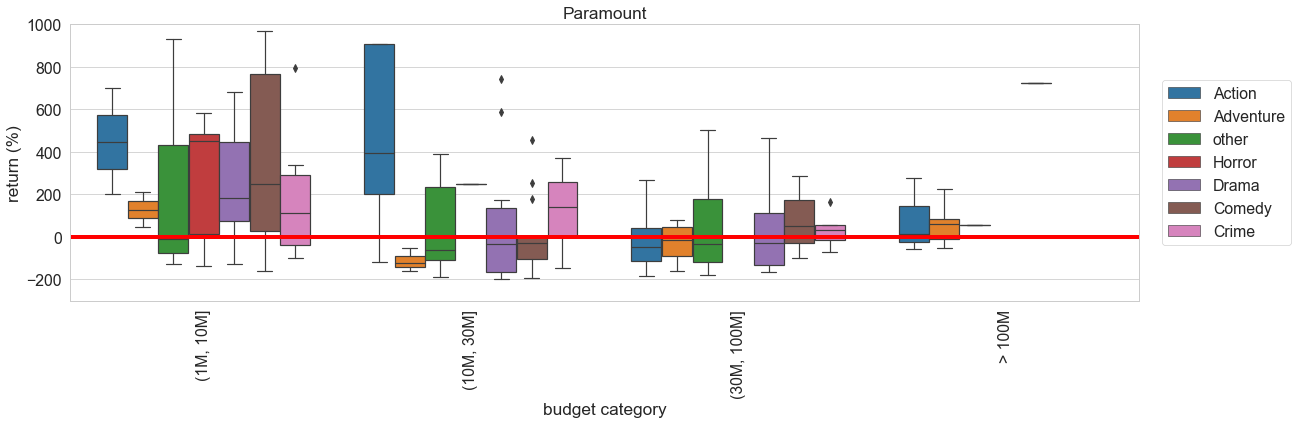

In [51]:
company = 'Paramount' 
filter_UP = (df.first_production_companies == company)
prep.plot_return_filter(df,filter_add = filter_cond & filter_UP,
                   hue_by = 'select_genres',
                   hue_order = list(df.select_genres.unique()),
                   _xlim = (2.5,6.5),
                   _ylim = (-300,1000),
                   _title = company)

In [52]:
#Having sufficient data, optimize return (max median) and minimaze risk (min std) 
#Select budget range, company and genre
d = df[filter_cond & filter_other_company 
               & filter_missing_company]\
               .groupby(['budget_category'
                         ,'select_production_companies'
                         ,'select_genres'])['gain/loss_%']\
               .agg(['count','median','std'])#\

d[d['count']>5].sort_values(by=['median','std'],axis=0,
                           ascending=[False,True]).head(20)

count  median  \
budget_category select_production_companies select_genres                  
(1M, 10M]       United Artists              Adventure          8 1127.52   
                Universal Pictures          Action             6  871.50   
                Fox Searchlight Pictures    Comedy             9  871.27   
                New Line Cinema             Horror             7  695.86   
                Walt Disney Pictures        other              6  519.70   
                United Artists              other              6  286.43   
(10M, 30M]      New Line Cinema             Horror             6  209.33   
> 100M          Warner Bros. Pictures       Adventure          6  195.90   
(1M, 10M]       RKO Radio Pictures          other              6  195.05   
                Columbia Pictures           Comedy             6  193.37   
                20th Century Fox            Drama              8  191.76   
                Paramount                   Drama              9  183.33   
(10k, 1M]       Metro-Goldwyn-Mayer         Drama              8  177.35   
(10M, 30M]      Universal Pictures          Comedy            17  150.58   
(30M, 100M]     Universal Pictures          Adventure         10  122.67   
(1M, 10M]       Paramount                   Crime              8  113.12   
(10M, 30M]      Universal Pictures          Horror             6  107.30   
(30M, 100M]     Walt Disney Pictures        other             12  102.11   
(1M, 10M]       Warner Bros. Pictures       Action             8   97.23   
                                            Drama              8   90.00   

                                                              std  
budget_category select_production_companies select_genres          
(1M, 10M]       United Artists              Adventure      715.37  
                Universal Pictures          Action        1023.83  
                Fox Searchlight Pictures    Comedy         664.85  
                New Line Cinema             Horror         463.48  
                Walt Disney Pictures        other          503.48  
                United Artists              other          728.56  
(10M, 30M]      New Line Cinema             Horror         569.35  
> 100M          Warner Bros. Pictures       Adventure      171.12  
(1M, 10M]       RKO Radio Pictures          other          787.25  
                Columbia Pictures           Comedy         215.01  
                20th Century Fox            Drama          367.85  
                Paramount                   Drama          686.48  
(10k, 1M]       Metro-Goldwyn-Mayer         Drama          364.13  
(10M, 30M]      Universal Pictures          Comedy         405.14  
(30M, 100M]     Universal Pictures          Adventure      498.50  
(1M, 10M]       Paramount                   Crime          295.49  
(10M, 30M]      Universal Pictures          Horror         412.71  
(30M, 100M]     Walt Disney Pictures        other          573.68  
(1M, 10M]       Warner Bros. Pictures       Action         142.53  
                                            Drama          822.62

### Questions to answer: How much money to invest? In what company? In what genre? 
 * For (1M,10M) budget choose United Artists company, Adventure movies if agree with the risk.
 * For (1M,10M) budget choose New Line Cinema company, Horror movies if lower risk is desired.
 * For (1M,10M) budget choose Fox Searchlight Pictures, Comedy with good median to std ratio. 
 * For (10M, 30M) budget choose New Line Cinema, Horror if high median is a priority
 * For >=100M budget choose Warner Bros. Pictures, Adventure movies if high median is a priority
